In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import networkx as nx
from itertools import combinations
import holoviews as hv
from holoviews import opts, dim
import holoviews.plotting.bokeh

In [2]:
df = pd.read_csv("maindf.csv", index_col=0)
df

Runtime  IMDB  IMDB_Votes  \
Title                                                                      
Kate & Leopold                                     118   6.4     87745.0   
American Experience                                  1   8.6      2118.0   
In the Mood for Love                                98   8.1    161173.0   
My Son the Fanatic                                  87   6.8      1647.0   
Three Kings                                        114   7.1    178169.0   
...                                                ...   ...         ...   
Two of Us                                           99   7.2      3586.0   
Charter                                             94   6.2      1448.0   
The Bee Gees: How Can You Mend a Broken Heart      111   8.1      5423.0   
Moonage Daydream                                   135   7.7     13061.0   
I Care a Lot                                       118   6.4    141304.0   

                                               Rotten_Tomatoes  Metascore  \
Title                                                                       
Kate & Leopold                                            52.0       44.0   
American Experience                                        NaN        NaN   
In the Mood for Love                                      92.0       87.0   
My Son the Fanatic                                        79.0        NaN   
Three Kings                                               94.0       82.0   
...                                                        ...        ...   
Two of Us                                                  NaN       82.0   
Charter                                                  100.0        NaN   
The Bee Gees: How Can You Mend a Broken Heart             96.0       78.0   
Moonage Daydream                                          92.0       83.0   
I Care a Lot                                              78.0       66.0   

                                                Boxoffice  Release_Month  \
Title                                                                      
Kate & Leopold                                 47121859.0           12.0   
American Experience                                   NaN           10.0   
In the Mood for Love                            2738980.0            3.0   
My Son the Fanatic                               417683.0            1.0   
Three Kings                                    60652036.0           10.0   
...                                                   ...            ...   
Two of Us                                          5495.0            2.0   
Charter                                               NaN            3.0   
The Bee Gees: How Can You Mend a Broken Heart         NaN           12.0   
Moonage Daydream                                4218925.0            4.0   
I Care a Lot                                          NaN            2.0   

                                               Release_Year  Release_DOY  \
Title                                                                      
Kate & Leopold                                       2001.0        359.0   
American Experience                                  1988.0        278.0   
In the Mood for Love                                 2001.0         68.0   
My Son the Fanatic                                   1998.0          7.0   
Three Kings                                          1999.0        274.0   
...                                                     ...          ...   
Two of Us                                            2021.0         36.0   
Charter                                              2020.0         73.0   
The Bee Gees: How Can You Mend a Broken Heart        2020.0        347.0   
Moonage Daydream                                     2023.0        119.0   
I Care a Lot                                         2021.0         50.0   

                                               Rating_16+  ...  \
Title       

Oscar Correlation Graph

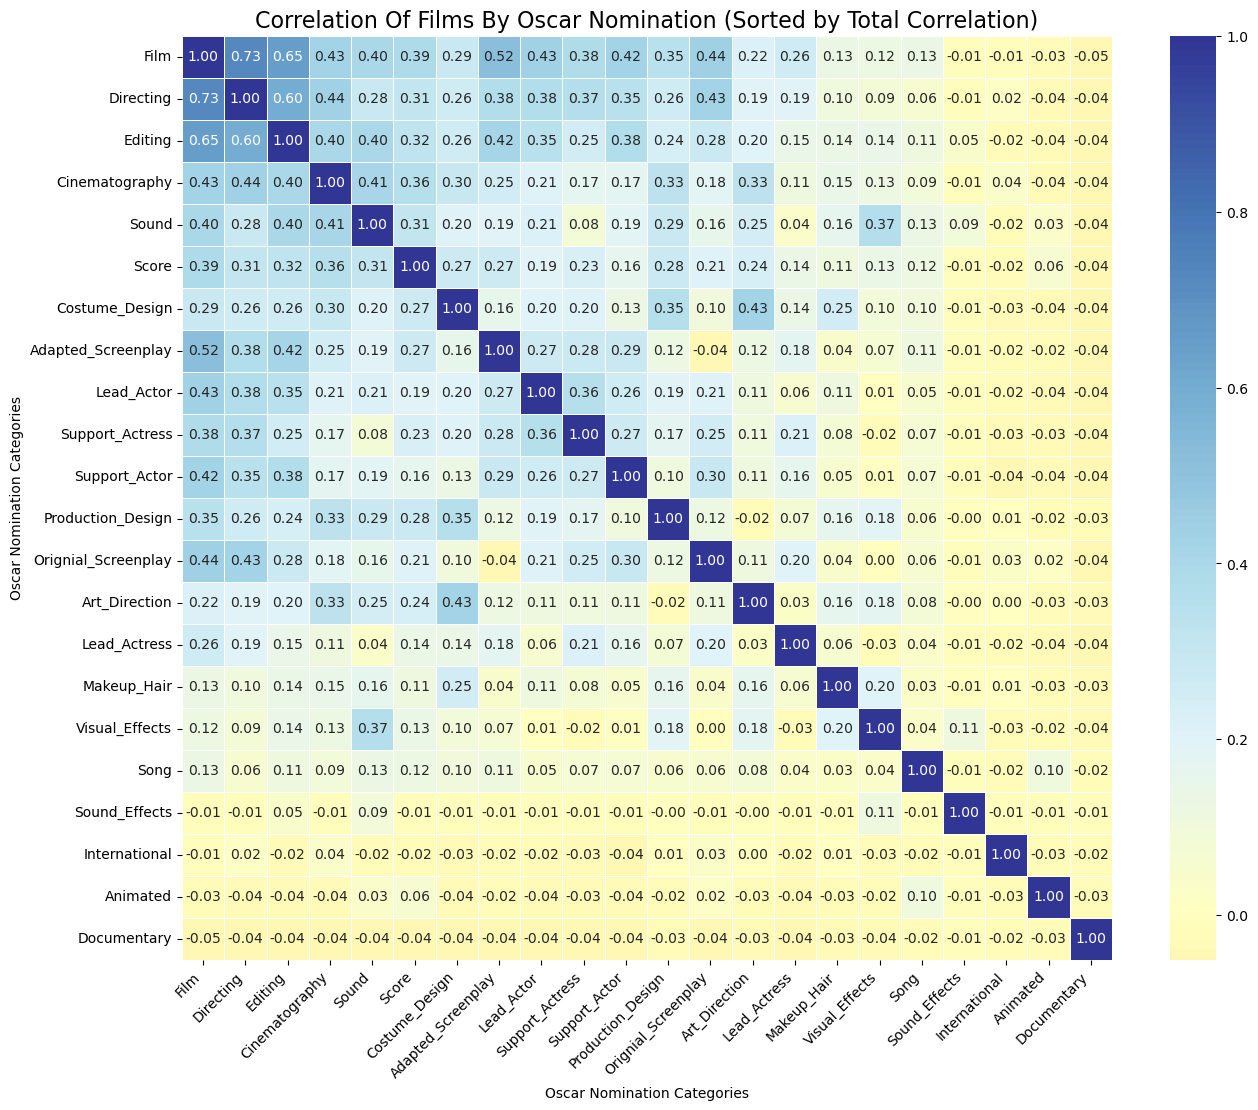

In [30]:
oscar_noms = df.loc[:, df.columns[df.columns.str.contains('Oscar') & df.columns.str.contains('nominated')]]
oscar_noms.columns = oscar_noms.columns.map(lambda x: x.split("'")[3] if isinstance(x, str) and 'Oscar' in x and '_nominated' in x else x)
oscar_noms['International'] = oscar_noms['International'] + oscar_noms['Non_English']
oscar_noms.drop(columns=["Non_English"], inplace=True)

# Calculate total correlation for each category
total_correlation = oscar_noms.corr().sum(axis=1)

# Sort columns based on total correlation
sorted_columns = total_correlation.sort_values(ascending=False).index
oscar_noms_sorted = oscar_noms[sorted_columns]

# Compute the correlation matrix
correlation_matrix = oscar_noms_sorted.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(15, 12))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu', fmt='.2f', linewidths=0.5, center=0)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Of Films By Oscar Nomination (Sorted by Total Correlation)', fontsize=16)
plt.xlabel('Oscar Nomination Categories')
plt.ylabel('Oscar Nomination Categories')
plt.show()

Ratings Websites

In [3]:
ratings = df[["IMDB", "Rotten_Tomatoes", "Metascore"]].dropna()

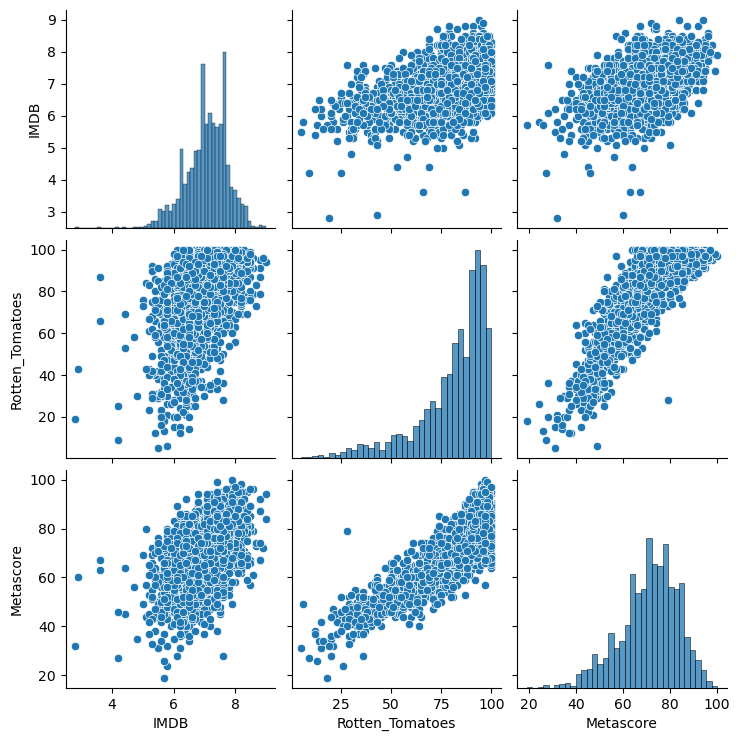

In [4]:
sns.pairplot(ratings)

<Axes: >

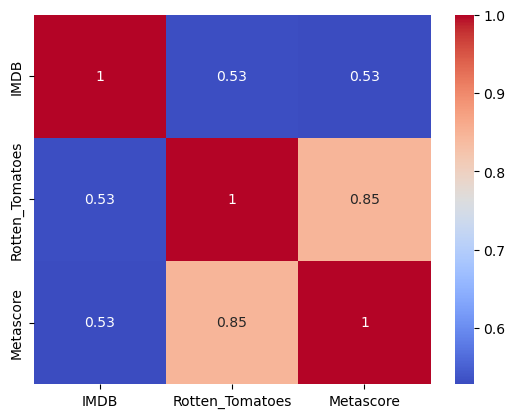

In [5]:
sns.heatmap(ratings.corr(), annot=True, cmap='coolwarm')

In [6]:
# Create a 3D scatter plot with labels as indices
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=ratings['Rotten_Tomatoes'],
    y=ratings['Metascore'],
    z=ratings['IMDB'],
    text=ratings.index,  # Use the index as labels
    mode='markers',
    marker=dict(
        size=8,
        color=ratings['IMDB'],  # You can use a different column for color if needed
        colorscale='Viridis',
        opacity=0.8
    )
))

# Update layout for better aspect ratio
fig.update_layout(scene=dict(
    aspectratio=dict(x=61/89, y=0.3),
    aspectmode='manual'
))

# Add labels to the axes
fig.update_layout(scene=dict(xaxis=dict(title='Rotten Tomatoes'),
                             yaxis=dict(title='Metascore'),
                             zaxis=dict(title='IMDB')))

# Show the plot
fig.show()

Rating To Score

In [7]:
advise = df.filter(regex='^Rating_|^IMDB$|^Boxoffice$').dropna()
advise.reset_index(inplace=True)
advise.columns = advise.columns.str.replace('Rating_', '')
advise = advise[["Title", "IMDB", "Boxoffice", "G", "PG", "PG-13", "R", "NC-17"]]

In [8]:
# Melt the DataFrame to long format for seaborn
advise_melt = pd.melt(advise, id_vars=['Title', 'IMDB', 'Boxoffice'], var_name='Rating', value_name='Value')

# Filter out rows where the value is 0 after melting
advise_melt = advise_melt[advise_melt['Value'] == 1]

# Create an interactive scatter plot with plotly
fig = px.scatter(
    advise_melt,
    x='Boxoffice',
    y='IMDB',
    color='Rating',
    hover_data=['Title', 'Rating', 'IMDB', 'Boxoffice'],
    title='Scatter Plot of IMDB vs Boxoffice with Movie Ratings',
    labels={'Boxoffice': 'Boxoffice', 'IMDB': 'IMDB'},
)

# Show the plot
fig.show()

Directors By Number Noms & Wins

In [9]:
# Filter columns with 'Director_' prefix
director_columns = df.filter(like='Director_')

# Create a new DataFrame with the director names
directors_df = pd.DataFrame({'Director': director_columns.columns})

# Initialize columns for the count of nominations and winners
directors_df['Nominated'] = 0
directors_df['Winner'] = 0

# Iterate over each row in the original DataFrame
for index, row in df.iterrows():
    # Iterate over each director column
    for director_col in director_columns.columns:
        # Check if the director worked on the movie
        if row[director_col] == 1:
            # Check if the movie was nominated
            nominated_columns = [col for col in row.index if 'nominated' in col.lower()]
            for nominated_col in nominated_columns:
                if row[nominated_col] == 1:
                    directors_df.loc[directors_df['Director'] == director_col, 'Nominated'] += 1
            
            # Check if the movie was a winner
            winner_columns = [col for col in row.index if 'winner' in col.lower()]
            for winner_col in winner_columns:
                if row[winner_col] == 1:
                    directors_df.loc[directors_df['Director'] == director_col, 'Winner'] += 1

# Remove Director_ prefix
directors_df['Director'] = directors_df['Director'].str.replace('Director_', '')

directors_df["Significance"] = directors_df["Nominated"] + directors_df["Winner"] * 5

In [10]:
director_plot_df = directors_df.sort_values(by='Significance', ascending=False).head(20)
director_plot_df = director_plot_df.sort_values(by='Winner', ascending=False)

fig = px.bar(director_plot_df, 
             x='Director', 
             y=['Nominated', 'Winner'], 
             barmode='group',
             labels={'value': 'Count', 'variable': ''},
             title='Film Award Nominations and Wins by Director From The 21st Century')

# Show the plot
fig.show()

Release Date vs. Boxoffice

In [11]:
rd = df[["Boxoffice", "Release_DOY"]].dropna()

fig3 = px.bar(rd, x='Release_DOY', y='Boxoffice', title='Release Day of Year Compared To Boxoffice')
fig3.show()

Network Graph

In [12]:
ng = df.filter(regex='^Writer_|^Director_')
ng.columns = ng.columns.str.replace('Writer_|Director_', '')
ng = ng.groupby(axis=1, level=0).sum().clip(upper=1)
ng = ng[ng.sum(axis=1) > 1]
ng = ng.loc[:, ng.sum() > 1]
ng = ng.drop(columns=['Unknown'])

# Create an empty list to store pairs
pairs_list = []

# Iterate over rows in the original DataFrame
for index, row in ng.iterrows():
    # Find the names of people who worked on the current movie
    working_people = row.index[row == 1].tolist()

    # Generate pairs of people who worked together using combinations
    pairs = list(combinations(working_people, 2))

    # Add pairs to the list
    pairs_list.extend(pairs)

# Create a new DataFrame with the pairs
ng = pd.DataFrame(pairs_list, columns=['Person1', 'Person2'])

ng

/var/folders/g7/gnzs3l6x61xcl7ny9d10xjjm0000gn/T/ipykernel_23461/3482151213.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.



Person1                Person2
0        James Mangold          Steven Rogers
1     David O. Russell            John Ridley
2          Ash Brannon          John Lasseter
3          Ash Brannon            Lee Unkrich
4          Ash Brannon            Pete Docter
...                ...                    ...
1440     Andrew Lanham  Destin Daniel Cretton
1441     Dave Callaham  Destin Daniel Cretton
1442      Edgar Wright   Krysty Wilson-Cairns
1443   Angelo Tijssens            Lukas Dhont
1444    Kevin Willmott              Spike Lee

[1445 rows x 2 columns]

In [13]:
from_list = ng["Person1"].tolist()
to_list = ng["Person2"].tolist()

node_list = from_list + to_list
node_list = list(set(node_list))

In [14]:
G = nx.Graph()
for i in range(len(node_list)):
    G.add_node(node_list[i])
    G.add_edges_from([(from_list[i], to_list[i])])

In [15]:
pos = nx.spring_layout(G, k=0.5, iterations=100)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

In [16]:
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

In [17]:
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='ice',
        reversescale=True,
        color=[],
        size=5,
        colorbar=dict(
            thickness=1,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color'] += tuple([len(adjacencies[1])])
    node_info = adjacencies[0]
    node_trace['text'] += tuple([node_info])

In [18]:
title = "Network Graph Demonstration"
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                title=title,
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=21, l=5, r=5, t=40),
                xaxis=dict(showgrid=False, zeroline=False,
                           showticklabels=False, mirror=True),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, mirror=True)))
fig.show()

Genre Chord

In [19]:
genre = df.filter(regex='^Genre')
genre.columns = genre.columns.str.replace('Genre_', '')
genre = genre.drop(columns=['Unknown', 'Family', 'Musical', 'News', 'Reality-TV', 'Short', 'Sport', 'Western'])
genres = pd.DataFrame(genre.columns)
genres.columns = ["Genre"]

Action  Adventure  Animation  \
Title                                                                         
Kate & Leopold                                      0          0          0   
American Experience                                 0          0          0   
In the Mood for Love                                0          0          0   
My Son the Fanatic                                  0          0          0   
Three Kings                                         1          1          0   
...                                               ...        ...        ...   
Two of Us                                           0          0          0   
Charter                                             0          0          0   
The Bee Gees: How Can You Mend a Broken Heart       0          0          0   
Moonage Daydream                                    0          0          0   
I Care a Lot                                        0          0          0   

                                               Biography  Comedy  Crime  \
Title                                                                     
Kate & Leopold                                         0       1      0   
American Experience                                    1       0      0   
In the Mood for Love                                   0       0      0   
My Son the Fanatic                                     0       1      0   
Three Kings                                            0       1      0   
...                                                  ...     ...    ...   
Two of Us                                              0       0      0   
Charter                                                0       0      0   
The Bee Gees: How Can You Mend a Broken Heart          1       0      0   
Moonage Daydream                                       1       0      0   
I Care a Lot                                           0       1      1   

                                               Documentary  Drama  Fantasy  \
Title                                                                        
Kate & Leopold                                           0      0        1   
American Experience                                      1      0        0   
In the Mood for Love                                     0      1        0   
My Son the Fanatic                                       0      1        0   
Three Kings                                              0      0        0   
...                                                    ...    ...      ...   
Two of Us                                                0      1        0   
Charter                                                  0      1        0   
The Bee Gees: How Can You Mend a Broken Heart            1      0        0   
Moonage Daydream                                         1      0        0   
I Care a Lot                                             0      1        0   

                                               History  Horror  Music  \
Title                                                                   
Kate & Leopold                                       0       0      0   
American Experience                                  1       0      0   
In the Mood for Love                                 0       0      0   
My Son the Fanatic                                   0       0      0   
Three Kings                                          0       0      0   
...                                                ...     ...    ...   
Two of Us                                            0       0      0   
Charter                                              0       0      0   
The Bee Gees: How Can You Mend a Broken Heart        0       0      1   
Moonage Daydream                                     1       0      0   
I Care a Lot                                         0       0      0   

                                               Mystery  Romance  Sci-Fi  \
Tit

In [20]:
# Create a list of all combinations of genres
all_combinations = list(combinations(genre.columns, 2))

# Create a new dataframe with the combinations as the first two columns
genre_pairs = pd.DataFrame(all_combinations, columns=['Genre1', 'Genre2'])

# Initialize the third column with zeros
genre_pairs['Count'] = 0

# Loop through each row in the original dataframe and update the count in the new dataframe
for _, row in genre.iterrows():
    genre_combinations = list(combinations(row.index[row == 1].tolist(), 2))
    for combination in genre_combinations:
        genre_pairs.loc[(genre_pairs['Genre1'] == combination[0]) & (genre_pairs['Genre2'] == combination[1]), 'Count'] += 1


In [21]:
# Replace values in genre_pairs with index numbers from genres DataFrame
genre_pairs['Genre1'] = genre_pairs['Genre1'].map(genres.reset_index().set_index('Genre')['index'])
genre_pairs['Genre2'] = genre_pairs['Genre2'].map(genres.reset_index().set_index('Genre')['index'])
genre_pairs

Genre1  Genre2  Count
0         0       1    146
1         0       2     27
2         0       3     17
3         0       4     20
4         0       5     31
..      ...     ...    ...
131      13      15     11
132      13      16      7
133      14      15      8
134      14      16      0
135      15      16      3

[136 rows x 3 columns]

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
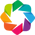

:Chord   [Genre1,Genre2]   (Count)

In [23]:
hv.extension('bokeh')
hv.output(size=200)

nodes = hv.Dataset(pd.DataFrame(genres['Genre']), 'index')

chord = hv.Chord((genre_pairs, nodes)).select(value=(5, None))

chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('Genre1').str(), 
               labels='Genre', node_color=dim('index').str()))